In [1]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [2]:
import pickle
import numpy as np

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import datasets, models, transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [3]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [4]:
# Пока не используем, нужно мухлевать с входными файлами данных
#import torch.nn.functional as F
# квадратизация (рисайз с паддингом, чтоб не было искажений по типу круг-овал) {будем вставлять в Compose}
#class SquarePad:
#    def __call__(self, image):
#        img = Image.open(image)
#        .decode_jpeg(img, channels = 3)
#        w, h = image.size
        
#        max_wh = np.max([w, h])
#        hp = int((max_wh - w) / 2)
#        vp = int((max_wh - h) / 2)
#        padding = (hp, vp, hp, vp)
#        return F.pad(img, padding, 0, 'constant')

In [5]:
# используем враппер над датасетом для удобной работы

class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
       # transform = transforms.Compose([
       #     transforms.ToTensor(),
       #     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
       # ])
        if self.mode == 'train' or self.mode =='val':
            transform = transforms.Compose([
                 transforms.RandomResizedCrop(224),
                 transforms.RandomHorizontalFlip(),
                 transforms.ToTensor(),
                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                 ])
        else:
            transform = transforms.Compose([
                transforms.Resize(224),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                ])
        
        
        x = self.load_sample(self.files[index])
        #x = self._prepare_sample(x)
        #x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [6]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [7]:
TRAIN_DIR = Path('journey-springfield/train/simpsons_dataset')
TEST_DIR = Path('journey-springfield/testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [8]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [9]:
val_dataset = SimpsonsDataset(val_files, mode='val')

In [10]:
val_dataset

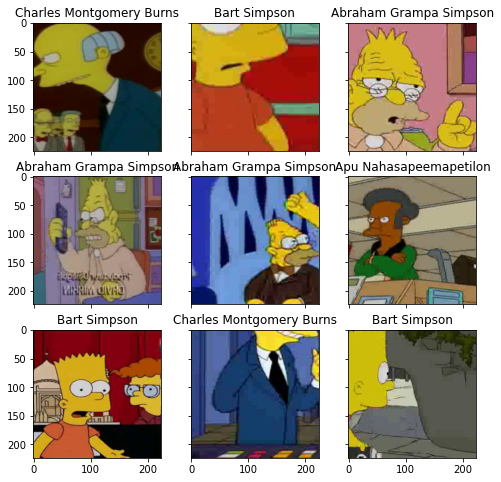

In [11]:
# Посмотрим на наших героев внутри датасета.

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

### Построение нейросети

*Описание слоев*:
1. размерность входа: 3x224x224 
2. размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [12]:
# Очень простая сеть
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [13]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [14]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [15]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [16]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [17]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2400, out_fea

####  Обучение

In [30]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [ ]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=5, batch_size=64)

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

## Подготовка на маленькой сети (AlexNet)

In [18]:
model_AlexNet = models.alexnet(pretrained=True)

In [19]:
model_AlexNet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

* **Fine Tuning** способ

In [ ]:
# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 9216
# Заменяем Fully-Connected слой на наш линейный классификатор
model_AlexNet.classifier = nn.Linear(num_features, n_classes)

# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_AlexNet = model_AlexNet.to(DEVICE)

In [ ]:
history = train(train_dataset, val_dataset, model=model_AlexNet, epochs=30, batch_size=64)

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

* **Feature Extractor** способ:

In [25]:
model_AlexNet_extractor = models.alexnet(pretrained=True)

In [26]:
for param in model_AlexNet_extractor.parameters():
    print(param.requires_grad)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [27]:
# замораживаем параметры (веса)
for param in model_AlexNet_extractor.parameters():
    param.requires_grad = False
    
# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 9216
# Заменяем Fully-Connected слой на наш линейный классификатор
model_AlexNet_extractor.classifier = nn.Linear(num_features, n_classes)

In [31]:
model_AlexNet_extractor =model_AlexNet_extractor.to(DEVICE)

In [32]:
history = train(train_dataset, val_dataset, model=model_AlexNet_extractor, epochs=30, batch_size=64)

epoch:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]

loss 2.7082797612298926


epoch:   3%|██▌                                                                         | 1/30 [01:31<43:58, 91.00s/it]


Epoch 001 train_loss: 2.7083     val_loss 2.4838 train_acc 0.4432 val_acc 0.5105
loss 2.5055651986239798


epoch:   7%|█████                                                                       | 2/30 [03:01<42:22, 90.80s/it]


Epoch 002 train_loss: 2.5056     val_loss 2.7544 train_acc 0.5195 val_acc 0.5063
loss 2.516326813449054


epoch:  10%|███████▌                                                                    | 3/30 [04:31<40:42, 90.45s/it]


Epoch 003 train_loss: 2.5163     val_loss 2.7412 train_acc 0.5485 val_acc 0.5315
loss 2.478616117884364


epoch:  13%|██████████▏                                                                 | 4/30 [06:01<39:10, 90.39s/it]


Epoch 004 train_loss: 2.4786     val_loss 2.9385 train_acc 0.5629 val_acc 0.5344
loss 2.5891171839367972


epoch:  17%|████████████▋                                                               | 5/30 [07:33<37:49, 90.76s/it]


Epoch 005 train_loss: 2.5891     val_loss 2.6996 train_acc 0.5734 val_acc 0.5608
loss 2.5803289435473102


epoch:  20%|███████████████▏                                                            | 6/30 [09:04<36:18, 90.76s/it]


Epoch 006 train_loss: 2.5803     val_loss 3.0577 train_acc 0.5770 val_acc 0.5386
loss 2.606854010557732


epoch:  23%|█████████████████▋                                                          | 7/30 [10:35<34:50, 90.90s/it]


Epoch 007 train_loss: 2.6069     val_loss 3.0435 train_acc 0.5830 val_acc 0.5520
loss 2.6067497242528987


epoch:  27%|████████████████████▎                                                       | 8/30 [12:06<33:18, 90.83s/it]


Epoch 008 train_loss: 2.6067     val_loss 3.0867 train_acc 0.5955 val_acc 0.5489
loss 2.700645494464097


epoch:  30%|██████████████████████▊                                                     | 9/30 [13:38<31:56, 91.25s/it]


Epoch 009 train_loss: 2.7006     val_loss 3.0737 train_acc 0.5902 val_acc 0.5630
loss 2.722669856648087


epoch:  33%|█████████████████████████                                                  | 10/30 [15:08<30:21, 91.06s/it]


Epoch 010 train_loss: 2.7227     val_loss 3.0961 train_acc 0.5958 val_acc 0.5619
loss 2.682090442509733


epoch:  37%|███████████████████████████▍                                               | 11/30 [16:39<28:45, 90.81s/it]


Epoch 011 train_loss: 2.6821     val_loss 3.2261 train_acc 0.6059 val_acc 0.5606
loss 2.69703789078982


epoch:  40%|██████████████████████████████                                             | 12/30 [18:10<27:18, 91.04s/it]


Epoch 012 train_loss: 2.6970     val_loss 3.2338 train_acc 0.6002 val_acc 0.5728
loss 2.7455491863836095


epoch:  43%|████████████████████████████████▌                                          | 13/30 [19:43<25:56, 91.54s/it]


Epoch 013 train_loss: 2.7455     val_loss 3.0387 train_acc 0.6069 val_acc 0.5877
loss 2.7909803393236565


epoch:  47%|███████████████████████████████████                                        | 14/30 [21:16<24:30, 91.90s/it]


Epoch 014 train_loss: 2.7910     val_loss 3.2875 train_acc 0.6042 val_acc 0.5743
loss 2.846446123720924


epoch:  50%|█████████████████████████████████████▌                                     | 15/30 [22:47<22:56, 91.77s/it]


Epoch 015 train_loss: 2.8464     val_loss 3.6076 train_acc 0.5982 val_acc 0.5487
loss 2.8427091544354384


epoch:  53%|████████████████████████████████████████                                   | 16/30 [24:20<21:29, 92.09s/it]


Epoch 016 train_loss: 2.8427     val_loss 3.5069 train_acc 0.6104 val_acc 0.5722
loss 2.8115353749067027


epoch:  57%|██████████████████████████████████████████▌                                | 17/30 [25:51<19:52, 91.77s/it]


Epoch 017 train_loss: 2.8115     val_loss 3.3302 train_acc 0.6068 val_acc 0.5716
loss 2.839253960266881


epoch:  60%|█████████████████████████████████████████████                              | 18/30 [27:21<18:15, 91.29s/it]


Epoch 018 train_loss: 2.8393     val_loss 3.4294 train_acc 0.6064 val_acc 0.5709
loss 2.7669828925226


epoch:  63%|███████████████████████████████████████████████▌                           | 19/30 [28:36<15:51, 86.48s/it]


Epoch 019 train_loss: 2.7670     val_loss 3.4861 train_acc 0.6107 val_acc 0.5753
loss 2.9083369214547363


epoch:  67%|██████████████████████████████████████████████████                         | 20/30 [29:50<13:46, 82.61s/it]


Epoch 020 train_loss: 2.9083     val_loss 3.1904 train_acc 0.6070 val_acc 0.5862
loss 2.9261700069686394


epoch:  70%|████████████████████████████████████████████████████▌                      | 21/30 [31:04<11:59, 79.99s/it]


Epoch 021 train_loss: 2.9262     val_loss 3.4304 train_acc 0.6047 val_acc 0.5923
loss 2.8626335302472334


epoch:  73%|██████████████████████████████████████████████████████▉                    | 22/30 [32:19<10:27, 78.45s/it]


Epoch 022 train_loss: 2.8626     val_loss 3.3162 train_acc 0.6115 val_acc 0.5915
loss 2.833098236197339


epoch:  77%|█████████████████████████████████████████████████████████▌                 | 23/30 [33:34<09:03, 77.58s/it]


Epoch 023 train_loss: 2.8331     val_loss 3.5164 train_acc 0.6206 val_acc 0.5797
loss 2.9863627923583596


epoch:  80%|████████████████████████████████████████████████████████████               | 24/30 [34:50<07:41, 76.90s/it]


Epoch 024 train_loss: 2.9864     val_loss 3.4395 train_acc 0.6140 val_acc 0.5885
loss 2.8699212502245617


epoch:  83%|██████████████████████████████████████████████████████████████▌            | 25/30 [36:04<06:20, 76.20s/it]


Epoch 025 train_loss: 2.8699     val_loss 3.6993 train_acc 0.6248 val_acc 0.5678
loss 2.8485307790069903


epoch:  87%|█████████████████████████████████████████████████████████████████          | 26/30 [37:18<05:01, 75.50s/it]


Epoch 026 train_loss: 2.8485     val_loss 3.3793 train_acc 0.6212 val_acc 0.5885
loss 2.907768920102889


epoch:  90%|███████████████████████████████████████████████████████████████████▌       | 27/30 [38:32<03:45, 75.02s/it]


Epoch 027 train_loss: 2.9078     val_loss 3.5433 train_acc 0.6167 val_acc 0.5904
loss 2.9501711688639136


epoch:  93%|██████████████████████████████████████████████████████████████████████     | 28/30 [39:47<02:29, 74.94s/it]


Epoch 028 train_loss: 2.9502     val_loss 3.5971 train_acc 0.6239 val_acc 0.5873
loss 2.91386567353367


epoch:  97%|████████████████████████████████████████████████████████████████████████▌  | 29/30 [41:01<01:14, 74.87s/it]


Epoch 029 train_loss: 2.9139     val_loss 3.9130 train_acc 0.6227 val_acc 0.5493
loss 2.9712543077807236


epoch: 100%|███████████████████████████████████████████████████████████████████████████| 30/30 [42:15<00:00, 84.52s/it]


Epoch 030 train_loss: 2.9713     val_loss 3.5592 train_acc 0.6215 val_acc 0.5879


In [33]:
loss, acc, val_loss, val_acc = zip(*history)

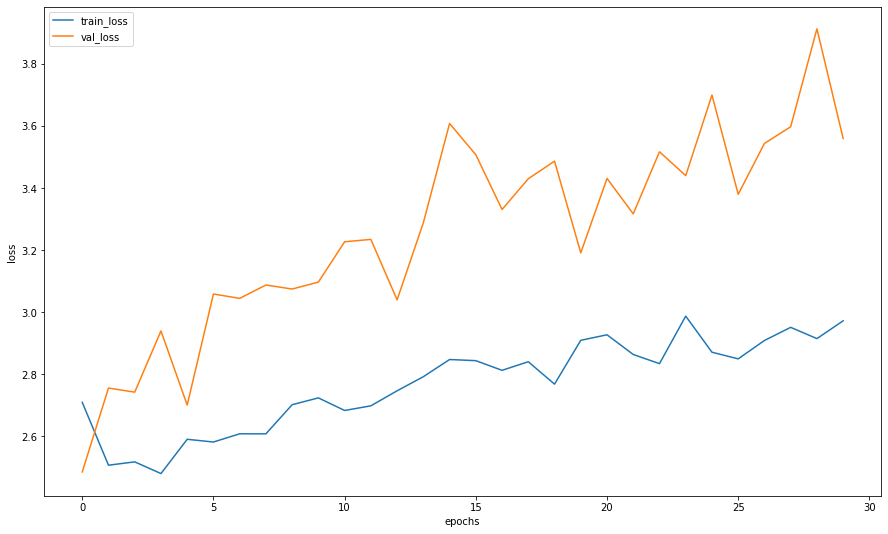

In [34]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

 **Смешанный** способ:
Мы будем обучать не только последний **fully connected** слой, но и несколько предпоследних

In [19]:
model__AlexNet_mixed = models.alexnet(pretrained=True)

In [21]:
layers_to_unfreeze = 5

In [22]:
for param in model__AlexNet_mixed.features[:-layers_to_unfreeze].parameters():
    param.requires_grad = False
    
num_features = 9216
# Заменяем Fully-Connected слой на наш линейный классификатор
model__AlexNet_mixed.classifier = nn.Linear(num_features,  n_classes)

model__AlexNet_mixed =model__AlexNet_mixed.to(DEVICE)

In [38]:
history = train(train_dataset, val_dataset, model=model__AlexNet_mixed, epochs=30, batch_size=64)

epoch:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]

loss 2.021260555181255


epoch:   3%|██▌                                                                         | 1/30 [01:17<37:21, 77.28s/it]


Epoch 001 train_loss: 2.0213     val_loss 1.4132 train_acc 0.4739 val_acc 0.6381
loss 1.3196492886966988


epoch:   7%|█████                                                                       | 2/30 [02:32<35:36, 76.30s/it]


Epoch 002 train_loss: 1.3196     val_loss 1.2666 train_acc 0.6570 val_acc 0.6630
loss 1.1099216692371272


epoch:  10%|███████▌                                                                    | 3/30 [03:49<34:29, 76.66s/it]


Epoch 003 train_loss: 1.1099     val_loss 1.1112 train_acc 0.7084 val_acc 0.7100
loss 1.0379139295853856


epoch:  13%|██████████▏                                                                 | 4/30 [05:06<33:10, 76.56s/it]


Epoch 004 train_loss: 1.0379     val_loss 1.0417 train_acc 0.7239 val_acc 0.7318
loss 0.9847401760666148


epoch:  17%|████████████▋                                                               | 5/30 [06:21<31:44, 76.17s/it]


Epoch 005 train_loss: 0.9847     val_loss 1.0105 train_acc 0.7411 val_acc 0.7375
loss 0.9035443160019678


epoch:  20%|███████████████▏                                                            | 6/30 [07:38<30:35, 76.46s/it]


Epoch 006 train_loss: 0.9035     val_loss 0.9999 train_acc 0.7635 val_acc 0.7442
loss 0.8951801969918622


epoch:  23%|█████████████████▋                                                          | 7/30 [08:54<29:09, 76.06s/it]


Epoch 007 train_loss: 0.8952     val_loss 0.9531 train_acc 0.7690 val_acc 0.7489
loss 0.8682020011126779


epoch:  27%|████████████████████▎                                                       | 8/30 [10:09<27:49, 75.87s/it]


Epoch 008 train_loss: 0.8682     val_loss 0.9294 train_acc 0.7744 val_acc 0.7595
loss 0.850369618435454


epoch:  30%|██████████████████████▊                                                     | 9/30 [11:25<26:30, 75.75s/it]


Epoch 009 train_loss: 0.8504     val_loss 0.9874 train_acc 0.7780 val_acc 0.7491
loss 0.8410262836435128


epoch:  33%|█████████████████████████                                                  | 10/30 [12:40<25:13, 75.68s/it]


Epoch 010 train_loss: 0.8410     val_loss 0.9236 train_acc 0.7836 val_acc 0.7713
loss 0.8112202760018895


epoch:  37%|███████████████████████████▍                                               | 11/30 [13:56<23:57, 75.64s/it]


Epoch 011 train_loss: 0.8112     val_loss 0.9605 train_acc 0.7920 val_acc 0.7434
loss 0.7905611481129102


epoch:  40%|██████████████████████████████                                             | 12/30 [15:11<22:41, 75.64s/it]


Epoch 012 train_loss: 0.7906     val_loss 0.8973 train_acc 0.7930 val_acc 0.7789
loss 0.7883481178718643


epoch:  43%|████████████████████████████████▌                                          | 13/30 [16:27<21:24, 75.56s/it]


Epoch 013 train_loss: 0.7883     val_loss 0.8882 train_acc 0.7931 val_acc 0.7801
loss 0.757492002315928


epoch:  47%|███████████████████████████████████                                        | 14/30 [17:42<20:08, 75.53s/it]


Epoch 014 train_loss: 0.7575     val_loss 0.8800 train_acc 0.8024 val_acc 0.7805
loss 0.7691731317437099


epoch:  50%|█████████████████████████████████████▌                                     | 15/30 [18:57<18:52, 75.48s/it]


Epoch 015 train_loss: 0.7692     val_loss 0.9385 train_acc 0.8026 val_acc 0.7816
loss 0.7449252175346242


epoch:  53%|████████████████████████████████████████                                   | 16/30 [20:13<17:36, 75.44s/it]


Epoch 016 train_loss: 0.7449     val_loss 0.8703 train_acc 0.8052 val_acc 0.7856
loss 0.7726031317286556


epoch:  57%|██████████████████████████████████████████▌                                | 17/30 [21:29<16:22, 75.57s/it]


Epoch 017 train_loss: 0.7726     val_loss 0.9022 train_acc 0.8006 val_acc 0.7818
loss 0.763476136068803


epoch:  60%|█████████████████████████████████████████████                              | 18/30 [22:46<15:14, 76.22s/it]


Epoch 018 train_loss: 0.7635     val_loss 0.9665 train_acc 0.8024 val_acc 0.7818
loss 0.7380915089005596


epoch:  63%|███████████████████████████████████████████████▌                           | 19/30 [24:03<13:58, 76.22s/it]


Epoch 019 train_loss: 0.7381     val_loss 0.8872 train_acc 0.8080 val_acc 0.7849
loss 0.7424916944972147


epoch:  67%|██████████████████████████████████████████████████                         | 20/30 [25:19<12:42, 76.30s/it]


Epoch 020 train_loss: 0.7425     val_loss 0.8721 train_acc 0.8067 val_acc 0.7841
loss 0.7414820014412931


epoch:  70%|████████████████████████████████████████████████████▌                      | 21/30 [26:35<11:24, 76.07s/it]


Epoch 021 train_loss: 0.7415     val_loss 0.8821 train_acc 0.8072 val_acc 0.7931
loss 0.7230598774371811


epoch:  73%|██████████████████████████████████████████████████████▉                    | 22/30 [27:51<10:08, 76.07s/it]


Epoch 022 train_loss: 0.7231     val_loss 0.9014 train_acc 0.8115 val_acc 0.7780
loss 0.741596942172247


epoch:  77%|█████████████████████████████████████████████████████████▌                 | 23/30 [29:06<08:50, 75.85s/it]


Epoch 023 train_loss: 0.7416     val_loss 0.8514 train_acc 0.8133 val_acc 0.7948
loss 0.7421736981931162


epoch:  80%|████████████████████████████████████████████████████████████               | 24/30 [30:22<07:34, 75.78s/it]


Epoch 024 train_loss: 0.7422     val_loss 0.8808 train_acc 0.8106 val_acc 0.7889
loss 0.7416339982193028


epoch:  83%|██████████████████████████████████████████████████████████████▌            | 25/30 [31:37<06:18, 75.73s/it]


Epoch 025 train_loss: 0.7416     val_loss 0.9270 train_acc 0.8101 val_acc 0.7744
loss 0.7427483938007463


epoch:  87%|█████████████████████████████████████████████████████████████████          | 26/30 [32:53<05:03, 75.78s/it]


Epoch 026 train_loss: 0.7427     val_loss 0.9236 train_acc 0.8090 val_acc 0.7721
loss 0.7547245889463594


epoch:  90%|███████████████████████████████████████████████████████████████████▌       | 27/30 [34:09<03:47, 75.90s/it]


Epoch 027 train_loss: 0.7547     val_loss 0.8939 train_acc 0.8097 val_acc 0.7868
loss 0.7340258750268415


epoch:  93%|██████████████████████████████████████████████████████████████████████     | 28/30 [35:26<02:32, 76.21s/it]


Epoch 028 train_loss: 0.7340     val_loss 0.8801 train_acc 0.8105 val_acc 0.7786
loss 0.7174493567078984


epoch:  97%|████████████████████████████████████████████████████████████████████████▌  | 29/30 [36:43<01:16, 76.27s/it]


Epoch 029 train_loss: 0.7174     val_loss 0.8803 train_acc 0.8169 val_acc 0.7908
loss 0.7084210939533095


epoch: 100%|███████████████████████████████████████████████████████████████████████████| 30/30 [37:59<00:00, 75.98s/it]


Epoch 030 train_loss: 0.7084     val_loss 0.8545 train_acc 0.8169 val_acc 0.7992


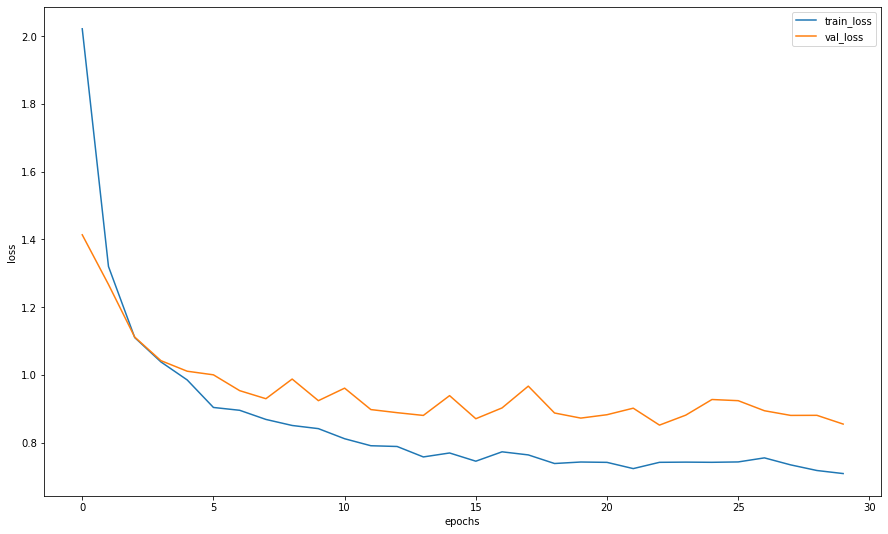

In [39]:
loss, acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [40]:
torch.save(model__AlexNet_mixed.state_dict(), 'model__AlexNet_mixed.pth')

In [23]:
model__AlexNet_mixed.load_state_dict(torch.load('model__AlexNet_mixed.pth'))

<All keys matched successfully>

In [24]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [26]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model__AlexNet_mixed, ex_img.unsqueeze(0))

In [28]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model__AlexNet_mixed, imgs)

In [29]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [30]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [31]:
actual_labels

[0, 6, 4, 0, 4, 4, 4, 6, 0, 0, 2, 0, 0, 0, 0, 2, 4, 6, 6, 2]

In [32]:
preds_class

['abraham_grampa_simpson',
 'charles_montgomery_burns',
 'bart_simpson',
 'milhouse_van_houten',
 'bart_simpson',
 'bart_simpson',
 'homer_simpson',
 'charles_montgomery_burns',
 'abraham_grampa_simpson',
 'abraham_grampa_simpson',
 'apu_nahasapeemapetilon',
 'abraham_grampa_simpson',
 'abraham_grampa_simpson',
 'bart_simpson',
 'moe_szyslak',
 'edna_krabappel',
 'bart_simpson',
 'charles_montgomery_burns',
 'charles_montgomery_burns',
 'apu_nahasapeemapetilon']

In [33]:
y_pred

array([ 0,  6,  4, 25,  4,  4, 15,  6,  0,  0,  2,  0,  0,  4, 27, 11,  4,
        6,  6,  2], dtype=int64)

In [34]:
from sklearn.metrics import f1_score

#f1_score(actual_labels, preds_class)
f1_score(actual_labels, y_pred, average='micro')

0.75

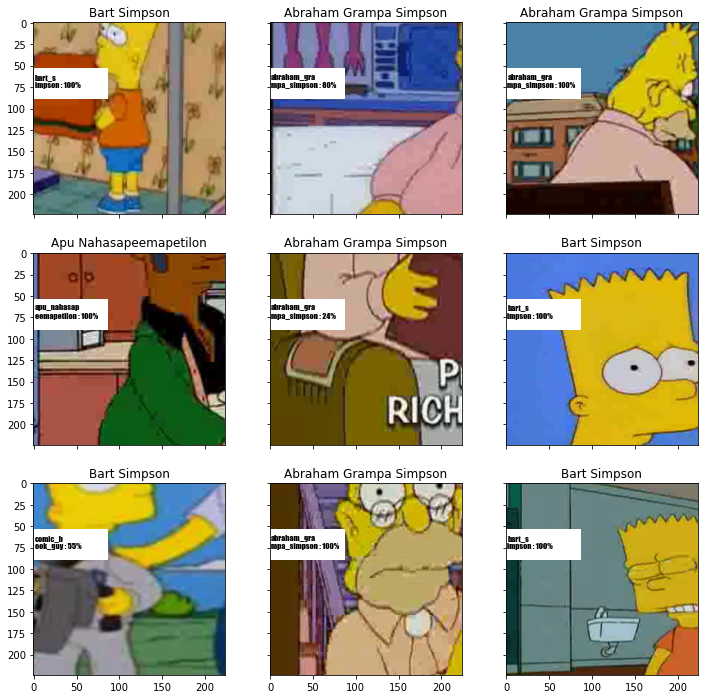

In [36]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model__AlexNet_mixed, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

In [38]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model__AlexNet_mixed, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [39]:
len(preds)

991

In [41]:
# ДОБАВЛЕНО: создание сабмита
import pandas as pd
df = pd.DataFrame()
df['Id'] = test_filenames
df['Expected'] = preds
df.to_csv('simpsons_simple_cnn_baseline.csv', index=False)

In [42]:
df.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon
